In [3]:
# Upload the zip file
from google.colab import files
uploaded = files.upload()

# Unzip the uploaded file
import zipfile
import os

for file_name in uploaded.keys():
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('/content')

# Change directory to the unzipped folder (replace 'YourFolderName' with the actual folder name)
os.chdir('/content/arc')

# Load the JSON files
import json

# Load the training challenges and solutions
with open('arc-agi_training_challenges.json', 'r') as file:
    training_challenges = json.load(file)

with open('arc-agi_training_solutions.json', 'r') as file:
    training_solutions = json.load(file)

# Load the evaluation challenges and solutions
with open('arc-agi_evaluation_challenges.json', 'r') as file:
    evaluation_challenges = json.load(file)

with open('arc-agi_evaluation_solutions.json', 'r') as file:
    evaluation_solutions = json.load(file)

# Check the contents to ensure they are loaded correctly
print("Training Challenges:", training_challenges)
print("Training Solutions:", training_solutions)
print("Evaluation Challenges:", evaluation_challenges)
print("Evaluation Solutions:", evaluation_solutions)


Saving arc.zip to arc (1).zip
Training Challenges: {'007bbfb7': {'test': [{'input': [[7, 0, 7], [7, 0, 7], [7, 7, 0]]}], 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]], 'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7]]}, {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]], 'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 4, 0, 0, 0, 0]]}, {'input': [[0, 0, 0], [0, 0, 2], [2, 0, 2]], 'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 2, 0, 2], [

In [ ]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import json

# Define the padding function
def pad_grid(grid, target_size=(30, 30)):
    if grid.ndim != 2:
        raise ValueError(f"Grid should have 2 dimensions, but has {grid.ndim}")
    padded_grid = np.zeros(target_size, dtype=int)
    padded_grid[:grid.shape[0], :grid.shape[1]] = grid
    return padded_grid

# Define the dataset class
class ARCDataset(Dataset):
    def __init__(self, challenges, solutions):
        self.challenges = challenges
        self.solutions = solutions
        self.keys = list(challenges.keys())
        self.valid_keys = self._filter_valid_keys()

    def __len__(self):
        return len(self.valid_keys)

    def __getitem__(self, idx):
        key = self.valid_keys[idx]
        challenge = self.challenges[key]
        solution = self.solutions[key]

        # Extracting and padding the train and test grids
        train_inputs = [pad_grid(np.array(pair['input'])) for pair in challenge['train']]
        train_outputs = [pad_grid(np.array(pair['output'])) for pair in challenge['train']]
        test_inputs = [pad_grid(np.array(pair['input'])) for pair in challenge['test']]
        test_outputs = [pad_grid(np.array(output)) for output in solution]

        # Convert to tensors
        train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
        train_outputs = torch.tensor(train_outputs, dtype=torch.float32)
        test_inputs = torch.tensor(test_inputs, dtype=torch.float32)
        test_outputs = torch.tensor(test_outputs, dtype=torch.float32)

        # Ensure the inputs have the correct dimensions
        train_inputs = train_inputs.unsqueeze(1)
        train_outputs = train_outputs.unsqueeze(1)
        test_inputs = test_inputs.unsqueeze(1)
        test_outputs = test_outputs.unsqueeze(1)

        return train_inputs, train_outputs, test_inputs, test_outputs

    def _filter_valid_keys(self):
        valid_keys = []
        for key in self.keys:
            challenge = self.challenges[key]
            if all('input' in pair and np.array(pair['input']).ndim == 2 for pair in challenge['train']) and \
               all('output' in pair and np.array(pair['output']).ndim == 2 for pair in challenge['train']) and \
               all('input' in pair and np.array(pair['input']).ndim == 2 for pair in challenge['test']):
                valid_keys.append(key)
            else:
                print(f"Skipping challenge {key} due to invalid grid dimensions")
        return valid_keys

# Load data from JSON files
with open('arc-agi_training_challenges.json') as f:
    training_challenges = json.load(f)
with open('arc-agi_training_solutions.json') as f:
    training_solutions = json.load(f)
with open('arc-agi_evaluation_challenges.json') as f:
    evaluation_challenges = json.load(f)
with open('arc-agi_evaluation_solutions.json') as f:
    evaluation_solutions = json.load(f)
with open('arc-agi_test_challenges.json') as f:
    test_challenges = json.load(f)

# Create DataLoader for training data
train_dataset = ARCDataset(training_challenges, training_solutions)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Define the neural network model
class ARCNN(nn.Module):
    def __init__(self):
        super(ARCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 30 * 30, 512)
        self.fc2 = nn.Linear(512, 30 * 30)

    def forward(self, x):
        batch_size, num_pairs, _, height, width = x.size()
        x = x.view(batch_size * num_pairs, 1, height, width)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(batch_size, num_pairs, 1, height, width)
        return x

# Instantiate the model, define loss function and optimizer
model = ARCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for train_inputs, train_outputs, _, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(train_inputs)
        # Align target size with input size
        target_size = outputs.size()
        train_outputs = train_outputs.view(target_size)
        loss = criterion(outputs, train_outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')


Epoch [1/10], Loss: 1.150590
Epoch [2/10], Loss: 1.037373
Epoch [3/10], Loss: 0.932295
Epoch [4/10], Loss: 0.955130
Epoch [5/10], Loss: 0.835713
Epoch [6/10], Loss: 0.734574
Epoch [7/10], Loss: 0.703047
Epoch [8/10], Loss: 0.595698
Epoch [9/10], Loss: 0.518585
Epoch [10/10], Loss: 0.510559


In [ ]:
# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for test_inputs, test_outputs, _, _ in data_loader:
            outputs = model(test_inputs)
            target_size = outputs.size()
            test_outputs = test_outputs.view(target_size)
            loss = criterion(outputs, test_outputs)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Create DataLoader for evaluation data
evaluation_dataset = ARCDataset(evaluation_challenges, evaluation_solutions)
evaluation_loader = DataLoader(evaluation_dataset, batch_size=1, shuffle=False)

# Evaluate the model
evaluation_loss = evaluate_model(model, evaluation_loader)
print(f'Evaluation Loss: {evaluation_loss:.6f}')

Evaluation Loss: 1.829580


Epoch [1/10], Loss: 0.448566
Epoch [2/10], Loss: 0.458333
Epoch [3/10], Loss: 0.449019
Epoch [4/10], Loss: 0.389885
Epoch [5/10], Loss: 0.369256
Epoch [6/10], Loss: 0.334233
Epoch [7/10], Loss: 0.306392
Epoch [8/10], Loss: 0.284873
Epoch [9/10], Loss: 0.312435
Epoch [10/10], Loss: 0.272750


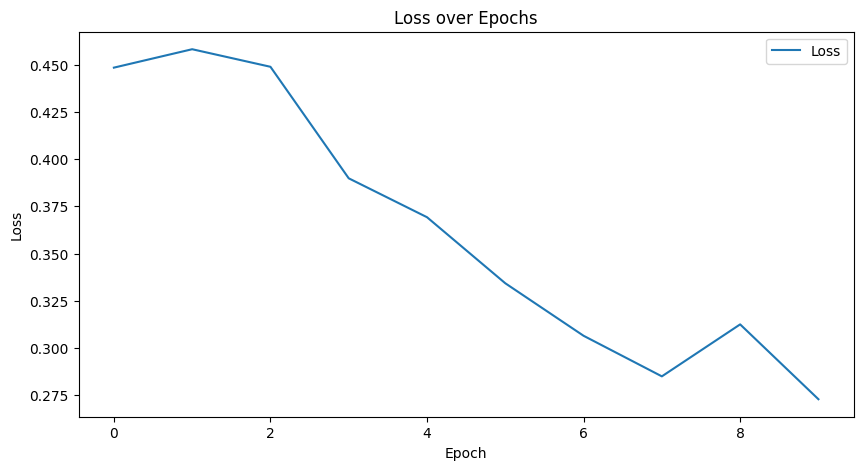

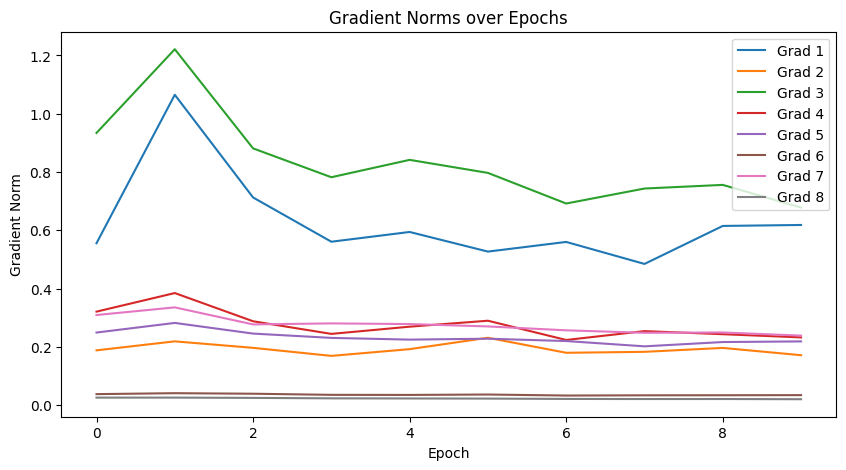

In [ ]:
import matplotlib.pyplot as plt

# Log gradients and loss
gradient_log = []
loss_log = []

# Training loop with gradient logging
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_gradients = []

    for train_inputs, train_outputs, _, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(train_inputs)
        # Align target size with input size
        target_size = outputs.size()
        train_outputs = train_outputs.view(target_size)
        loss = criterion(outputs, train_outputs)
        loss.backward()

        # Log gradients
        batch_gradients = []
        for param in model.parameters():
            if param.grad is not None:
                batch_gradients.append(param.grad.norm().item())
        epoch_gradients.append(batch_gradients)

        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_log.append(epoch_loss)

    # Average gradients for the epoch
    avg_epoch_gradients = np.mean(epoch_gradients, axis=0)
    gradient_log.append(avg_epoch_gradients)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

# Plot loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), loss_log, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plot gradients over epochs
plt.figure(figsize=(10, 5))
gradient_log = np.array(gradient_log).T
for i, grad in enumerate(gradient_log):
    plt.plot(range(num_epochs), grad, label=f'Grad {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms over Epochs')
plt.legend()
plt.show()


monitor gradient descendant and check global minima




No checkpoint found at 'checkpoint.pth.tar'


<ipython-input-4-2fc7a384ce71>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  train_inputs = torch.tensor(train_inputs, dtype=torch.float32)


Epoch [1/10], Loss: 1.070801, Grad Norm: 0.110714
Epoch [2/10], Loss: 1.041713, Grad Norm: 0.410719
Epoch [3/10], Loss: 1.115719, Grad Norm: 1.597455
Epoch [4/10], Loss: 0.904380, Grad Norm: 0.271972
Epoch [5/10], Loss: 0.797422, Grad Norm: 0.218305
Epoch [6/10], Loss: 0.731613, Grad Norm: 0.859687
Epoch [7/10], Loss: 0.739146, Grad Norm: 0.708631
Epoch [8/10], Loss: 0.691629, Grad Norm: 0.385409
Epoch [9/10], Loss: 0.752104, Grad Norm: 0.234191
Epoch [10/10], Loss: 0.667834, Grad Norm: 1.250794


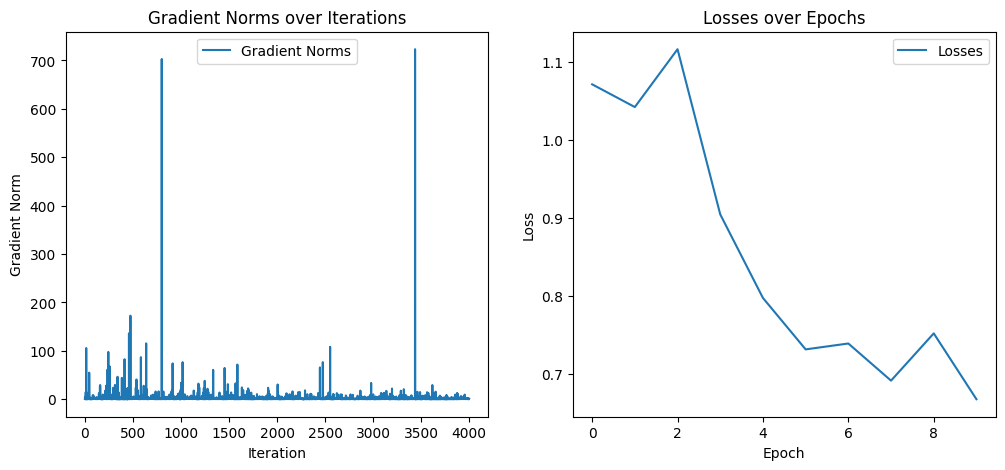

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import json
import os

# Define the padding function with additional logging
def pad_grid(grid, target_size=(30, 30)):
    if grid.ndim != 2:
        raise ValueError(f"Grid should have 2 dimensions, but has {grid.ndim}")
    padded_grid = np.zeros(target_size, dtype=int)
    padded_grid[:grid.shape[0], :grid.shape[1]] = grid
    return padded_grid

# Define the dataset class
class ARCDataset(Dataset):
    def __init__(self, challenges, solutions):
        self.challenges = challenges
        self.solutions = solutions
        self.keys = list(challenges.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        challenge = self.challenges[key]
        solution = self.solutions[key]

        # Extracting and padding the train and test grids
        train_inputs = [pad_grid(np.array(pair['input'])) for pair in challenge['train']]
        train_outputs = [pad_grid(np.array(pair['output'])) for pair in challenge['train']]
        test_inputs = [pad_grid(np.array(pair['input'])) for pair in challenge['test']]
        test_outputs = [pad_grid(np.array(output)) for output in solution]

        # Convert to tensors
        train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
        train_outputs = torch.tensor(train_outputs, dtype=torch.float32)
        test_inputs = torch.tensor(test_inputs, dtype=torch.float32)
        test_outputs = torch.tensor(test_outputs, dtype=torch.float32)

        # Ensure the inputs have the correct dimensions
        train_inputs = train_inputs.unsqueeze(1)
        train_outputs = train_outputs.unsqueeze(1)
        test_inputs = test_inputs.unsqueeze(1)
        test_outputs = test_outputs.unsqueeze(1)

        return train_inputs, train_outputs, test_inputs, test_outputs

# Load data from JSON files
with open('arc-agi_training_challenges.json') as f:
    training_challenges = json.load(f)
with open('arc-agi_training_solutions.json') as f:
    training_solutions = json.load(f)
with open('arc-agi_evaluation_challenges.json') as f:
    evaluation_challenges = json.load(f)
with open('arc-agi_evaluation_solutions.json') as f:
    evaluation_solutions = json.load(f)
with open('arc-agi_test_challenges.json') as f:
    test_challenges = json.load(f)

# Create DataLoader for training data
train_dataset = ARCDataset(training_challenges, training_solutions)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Define the neural network model
class ARCNN(nn.Module):
    def __init__(self):
        super(ARCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 30 * 30, 512)
        self.fc2 = nn.Linear(512, 30 * 30)

    def forward(self, x):
        batch_size, num_pairs, _, height, width = x.size()
        x = x.view(batch_size * num_pairs, 1, height, width)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(batch_size, num_pairs, 1, height, width)
        return x

# Instantiate the model, define loss function and optimizer
model = ARCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to save checkpoints
def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth.tar'):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(state, filename)

# Load checkpoint (if available)
def load_checkpoint(filename='checkpoint.pth.tar'):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Loaded checkpoint '{filename}' (epoch {start_epoch})")
        return start_epoch, loss
    else:
        print(f"No checkpoint found at '{filename}'")
        return 0, None

# Resume from the last checkpoint if available
start_epoch, _ = load_checkpoint()

# Arrays to store gradient norms and losses
grad_norms = []
losses = []

# Training loop
num_epochs = 10
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    for train_inputs, train_outputs, _, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(train_inputs)
        # Align target size with input size
        target_size = outputs.size()
        train_outputs = train_outputs.view(target_size)
        loss = criterion(outputs, train_outputs)
        loss.backward()

        # Log gradient norms
        total_norm = 0
        for p in model.parameters():
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)
        grad_norms.append(total_norm)

        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}, Grad Norm: {total_norm:.6f}')

    # Save checkpoint
    save_checkpoint(epoch, model, optimizer, epoch_loss)

# Plot the gradient norms and losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(grad_norms, label='Gradient Norms')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms over Iterations')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(losses, label='Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses over Epochs')
plt.legend()

plt.show()
